# Prédisez la consommation d'énergie des bâtiments dans la ville de Seattle.

<div align="left">
  <img src="https://user.oc-static.com/upload/2024/09/11/17260684381511_Capture%20d%E2%80%99e%CC%81cran%202024-09-11%20a%CC%80%2017.22.25.png" width="200px">
</div>

## **Objetif**: Prédire les **émissions de CO2** et la **consommation totale d’énergie** de **bâtiments non destinés à l’habitation**

- Auteur......: **Rafael CEREZO MARTIN**
- Date........: **Décembre 2025**

# <span style="color:red">PART 4. Modélisation avec sklearn.pipeline. Sur Dataset Clean V2</span>

# STEP 1. CONFIGURATION DU PROJET

## ⬇️ IMPORTATION DES LIBRAIRIES (STACK DE SCIENCE DES DONNÉES)

In [1]:
# ============================================================================
# 1. IMPORTATION DES LIBRAIRIES (STACK DE SCIENCE DES DONNÉES)
# ============================================================================

# Bibliothèques fondamentales pour la manipulation de données
import pandas            as pd          # Manipulation de DataFrames
import numpy             as np          # Calcul numérique et matrices
import matplotlib.pyplot as plt         # Visualisation de données
import seaborn           as sns         # Graphiques statistiques évolués

# Outils de sélection et validation de modèles
from   sklearn.model_selection import (
       train_test_split,                # Division du dataset (Train/Test)
       GridSearchCV,                    # Recherche d'hyperparamètres
       cross_validate,                  # Validation croisée robuste
)

# Métriques d'évaluation de performance
from   sklearn.metrics         import (
       mean_squared_error,              # Erreur quadratique moyenne (MSE)
       r2_score,                        # Coefficient de détermination R²
       mean_absolute_error,             # Erreur absolue moyenne (MAE)
)

# Prétraitement et ingénierie des caractéristiques
from   sklearn.compose         import ColumnTransformer    # Transformateur
from   sklearn.preprocessing   import (
       LabelEncoder,                    # Encodage des labels cibles
       OneHotEncoder,                   # Encodage variables catégorielles
       StandardScaler,                  # Normalisation des données
)

# Algorithmes de régression (Modèles)
from   sklearn.dummy           import DummyRegressor        # Modèle de base
from   sklearn.linear_model    import LinearRegression      # Régression linéaire
from   sklearn.svm             import SVR                   # Support Vector Reg.
from   sklearn.ensemble        import RandomForestRegressor # Forêts Aléatoires

print("\n============================================================================")
print("RAPPORT D'IMPORTATION DES MODULES")
print("============================================================================")
print(f"  Pandas version........: {pd.__version__}")
print(f"  Numpy version.........: {np.__version__}")
print("  Status................: ✅ Prêt pour l'analyse")
print("============================================================================")


RAPPORT D'IMPORTATION DES MODULES
  Pandas version........: 2.3.3
  Numpy version.........: 2.2.2
  Status................: ✅ Prêt pour l'analyse


## ❇️ LOAD AND EXPLORE DATASET

In [2]:
# Configuration des sources de données
dataset_url      = "dataset_Seattle_Feature_Engineering_V2.csv" # Source locale
df_clean         = pd.read_csv(dataset_url)                     # Chargement

# ----------------------------------------------------------------------------
# ÉTAT INITIAL DU DATASET
# ----------------------------------------------------------------------------
# Calcul des dimensions pour le rapport visuel
nb_lignes        = df_clean.shape[0]           # Nombre total d'observations
nb_colonnes      = df_clean.shape[1]           # Nombre total de variables
memoire_usage    = df_clean.memory_usage().sum() / 1024**2 # Taille en Mo

print("\n============================================================================")
print("RAPPORT INITIAL DU DATASET")
print("============================================================================")
print(f"  Source du fichier.....: {dataset_url}")
print(f"  Nombre de lignes......: {nb_lignes}")
print(f"  Nombre de colonnes....: {nb_colonnes}")
print(f"  Mémoire utilisée......: {memoire_usage:.2f} MB")
print("  Status................: ✅ Chargement réussi")
print("============================================================================")

# ############################################################################
# FONCTION : verification_types_donnees(df)
# ############################################################################
# Cette fonction analyse la pureté numérique du dataset pour éviter les 
# erreurs de calcul lors de la modélisation.
# ############################################################################
def verification_types_donnees(df):
    """
    Affiche un résumé des types de colonnes présents dans le DataFrame.
    """
    print("\n============================================================================")
    print("ANALYSE DES TYPES DE DONNÉES")
    print("============================================================================")
    
    # Identification des groupes de types
    cols_numeriques  = df.select_dtypes(include=[np.number]).columns
    cols_objets      = df.select_dtypes(include=['object']).columns
    
    print(f"  Variables numériques..: {len(cols_numeriques)}")
    print(f"  Variables objets......: {len(cols_objets)}")
    
    if len(cols_objets) > 0:
        print(f"  ⚠️ ATTENTION.........: {len(cols_objets)} colonnes non numériques détectées")
        print(f"  Détails objets........: {list(cols_objets[:5])}")
    else:
        print("  Validation............: ✅ Dataset 100% numérique")
    print("============================================================================")

# Appel de la fonction de diagnostic
verification_types_donnees(df_clean)


RAPPORT INITIAL DU DATASET
  Source du fichier.....: dataset_Seattle_Feature_Engineering_V2.csv
  Nombre de lignes......: 1668
  Nombre de colonnes....: 49
  Mémoire utilisée......: 0.61 MB
  Status................: ✅ Chargement réussi

ANALYSE DES TYPES DE DONNÉES
  Variables numériques..: 40
  Variables objets......: 8
  ⚠️ ATTENTION.........: 8 colonnes non numériques détectées
  Détails objets........: ['PropertyName', 'Address', 'TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType']


In [3]:
# Dictionnaire de métadonnées pour les graphiques 
meta_dict = {
    "OSEBuildingID"                   : "Identifiant unique du bâtiment",
    "DataYear"                        : "Année de relevé",
    "BuildingType"                    : "Type de bâtiment",
    "PrimaryPropertyType"             : "Utilisation principale du bâtiment",
    "PropertyName"                    : "Nom du bâtiment",
    "Address"                         : "Adresse postale",
    "City"                            : "Ville",
    "State"                           : "État",
    "ZipCode"                         : "Code postal",
    "TaxParcelIdentificationNumber"   : "Numéro de parcelle fiscale",
    "CouncilDistrictCode"             : "District du conseil",
    "Neighborhood"                    : "Quartier",
    "Latitude"                        : "Coordonnée Latitude",
    "Longitude"                       : "Coordonnée Longitude",
    "YearBuilt"                       : "Année de construction",
    "NumberofBuildings"               : "Nombre de bâtiments",
    "NumberofFloors"                  : "Nombre d'étages",
    "PropertyGFATotal"                : "Surface totale (pieds carrés)",
    "PropertyGFAParking"              : "Surface de parking",
    "PropertyGFABuilding(s)"          : "Surface bâtie",
    "ListOfAllPropertyUseTypes"       : "Liste des types d'utilisation",
    "LargestPropertyUseType"          : "Utilisation principale (GFA)",
    "LargestPropertyUseTypeGFA"       : "Surface de l'utilisation principale",
    "SecondLargestPropertyUseType"    : "Deuxième utilisation",
    "SecondLargestPropertyUseTypeGFA" : "Surface de la deuxième utilisation",
    "ThirdLargestPropertyUseType"     : "Troisième utilisation",
    "ThirdLargestPropertyUseTypeGFA"  : "Surface de la troisième utilisation",
    "YearsENERGYSTARCertified"        : "Années de certification ENERGY STAR",
    "ENERGYSTARScore"                 : "Score ENERGY STAR (0-100)",
    "SiteEUI(kBtu/sf)"                : "Intensité énergétique du site",
    "SiteEUIWN(kBtu/sf)"              : "Intensité énergétique du site (Normalisée)",
    "SourceEUI(kBtu/sf)"              : "Intensité énergétique à la source",
    "SourceEUIWN(kBtu/sf)"            : "Intensité énergétique à la source (Normalisée)",
    "SiteEnergyUse(kBtu)"             : "Consommation totale d'énergie",
    "SiteEnergyUseWN(kBtu)"           : "Consommation totale d'énergie (Normalisée)",
    "SteamUse(kBtu)"                  : "Vapeur de réseau consommée",
    "Electricity(kWh)"                : "Électricité consommée (kWh)",
    "Electricity(kBtu)"               : "Électricité consommée (kBtu)",
    "NaturalGas(therms)"              : "Gaz naturel consommé (therms)",
    "NaturalGas(kBtu)"                : "Gaz naturel consommé (kBtu)",
    "DefaultData"                     : "Données par défaut utilisées",
    "Comments"                        : "Commentaires",
    "ComplianceStatus"                : "Statut de conformité",
    "Outlier"                         : "Bâtiment atypique (Outlier)",
    "TotalGHGEmissions"               : "Émissions totales de GES",
    "GHGEmissionsIntensity"           : "Intensité d'émissions de GES"
}

## ⚙️ CONFIGURATION GLOBALE DU PROJET: FEATURE_TARGET, SEED, LEAKAGE_THRESHOLD

In [4]:
# ============================================================================
# 1.5 CONFIGURATION GLOBALE DU PROJET
# ============================================================================

# Définition de la variable cible du projet (Target)
FEATURE_TARGET    = "SiteEnergyUse(kBtu)"        # Variable à prédire

# Définition de l'état aléatoire pour la reproductibilité des résultats
# Le nombre 42 est un standard dans la communauté Data Science
SEED              = 42                          # État aléatoire global

# Seuil de corrélation pour la détection de Data Leakage (Fuga de datos)
LEAKAGE_THRESHOLD = 0.95                        # Seuil critique (95%)

# 1. Supprimer la limite de largeur de la console (définie à None)
pd.set_option('display.expand_frame_repr', False)

# 2. S’assurer que la largeur des colonnes est suffisante pour les noms longs
pd.set_option('display.max_colwidth', None)

# 3. (Optionnel) Si vous avez beaucoup de lignes, vous pouvez contrôler combien en afficher
pd.set_option('display.max_rows', 100)

# ----------------------------------------------------------------------------
# RAPPORT DE CONFIGURATION
# ----------------------------------------------------------------------------
print("\n============================================================================")
print("PARAMÈTRES DE CONFIGURATION INITIALISÉS")
print("============================================================================")
print(f"  Variable cible (Target)...: {FEATURE_TARGET}")
print(f"  Graine aléatoire (SEED)...: {SEED}")
print("  Status....................: ✅ Configuration prête")
print("============================================================================")


PARAMÈTRES DE CONFIGURATION INITIALISÉS
  Variable cible (Target)...: SiteEnergyUse(kBtu)
  Graine aléatoire (SEED)...: 42
  Status....................: ✅ Configuration prête


# STEP 2. ✂️ Split Dataset pour Train et Test

In [5]:
# ============================================================================
# DÉFINITION DES VARIABLES ET PARTITIONNEMENT DU DATASET
# ============================================================================

# Séparation des caractéristiques (X) et de la variable cible (y)
# FEATURE_TARGET doit être définie au préalable (ex: 'TotalGHGEmissions')
X_global         = df_clean.drop(columns=[FEATURE_TARGET])      # Prédicteurs
y_global         = df_clean[FEATURE_TARGET]                     # Cible (Target)

# Création des ensembles d'entraînement et de test (Hold-out method)
# On réserve 20% des données pour l'évaluation finale (Test Set)
X_train_global, \
X_test_global,  \
y_train_global, \
y_test_global    = train_test_split(
                   X_global, 
                   y_global, 
                   test_size    = 0.20,                         # Ratio 80/20
                   random_state = SEED                          # Reproductibilité
)

# ----------------------------------------------------------------------------
# RAPPORT DE SEGMENTATION DES DONNÉES
# ----------------------------------------------------------------------------
# Calcul des proportions pour vérification
prop_train       = (len(X_train_global) / len(X_global)) * 100
prop_test        = (len(X_test_global) / len(X_global)) * 100

print("\n============================================================================")
print("BILAN DU PARTITIONNEMENT (TRAIN/TEST SPLIT)")
print("============================================================================")
print(f"  Taille totale dataset.: {len(X_global)} lignes")
print(f"  Ensemble Train........: {len(X_train_global)} lignes ({prop_train:.1f}%)")
print(f"  Ensemble Test.........: {len(X_test_global)} lignes ({prop_test:.1f}%)")
print(f"  Variables prédictives.: {X_train_global.shape[1]}")
print("  Status................: ✅ Segmentation effectuée avec succès")
print("============================================================================")


BILAN DU PARTITIONNEMENT (TRAIN/TEST SPLIT)
  Taille totale dataset.: 1668 lignes
  Ensemble Train........: 1334 lignes (80.0%)
  Ensemble Test.........: 334 lignes (20.0%)
  Variables prédictives.: 48
  Status................: ✅ Segmentation effectuée avec succès


## ⬇️ Import Classe auxiliare pour analyse (DataCleaner)

In [6]:
# ============================================================================
# INITIALISATION DE L'INGÉNIERIE DES DONNÉES
# ============================================================================

# Importation de la classe personnalisée pour le prétraitement des données
# Cette classe centralise les méthodes de nettoyage et de validation.
from data_preprocessing import DataCleaner                   # Moteur d'audit

# Initialisation de l'instance de nettoyage
# On active 'verbose=True' pour obtenir un suivi détaillé des transformations.
cleaner_mod_aux  = DataCleaner(
                   df_clean,                                 # Dataset source
                   verbose = True                            # Mode bavard
)

print("\n============================================================================")
print("SYSTÈME DE PRÉTRAITEMENT INITIALISÉ")
print("============================================================================")
print(f"  Classe utilisée.......: {type(cleaner_mod_aux).__name__}")
print(f"  Mode détaillé (Verb)..: {cleaner_mod_aux.verbose}")
print(f"  Cible d'analyse.......: df_clean")
print("  Status................: ✅ Composant prêt pour l'audit")
print("============================================================================")


SYSTÈME DE PRÉTRAITEMENT INITIALISÉ
  Classe utilisée.......: DataCleaner
  Mode détaillé (Verb)..: True
  Cible d'analyse.......: df_clean
  Status................: ✅ Composant prêt pour l'audit


## 👤 Vérification de l'intégrité avant Modélisation

In [7]:
# ============================================================================
# EXÉCUTION DE L'AUDIT QUALITÉ FINAL
# ============================================================================

# Lancement de la batterie de tests sur les ensembles d'entraînement et de test.
# Cette méthode valide l'alignement, l'intégrité et la distribution.
cleaner_mod_aux.effectuer_audit_final(
    X_train = X_train_global,                                # Features Train
    X_test  = X_test_global,                                 # Features Test
    y_train = y_train_global,                                # Cible Train
    y_test  = y_test_global                                  # Cible Test
)

# ############################################################################
# ANALYSE POST-AUDIT
# ############################################################################
# Si le rapport affiche des anomalies de standardisation (μ != 0 ou σ != 1), 
# il est impératif de vérifier si certaines colonnes ont sauté l'étape 
# du StandardScaler ou si des fuites de données (Data Leakage) sont présentes.
# ############################################################################


VÉRIFICATIONS FINALES

✅ 1. Dimensions identiques
   Train : (1334, 48)
   Test  : (334, 48)

✅ 2. Colonnes alignées
   Nombre de features : 48

✅ 3. Pas de valeurs manquantes
   Status : 0 missing

📊 4. État des types de données
   Colonnes textuelles : 8
   ⚠️ ALERTE : 8 colonnes nécessitent un encodage via le Pipeline.

✅ 5. Cibles alignées avec les features
   Train : 1334 samples OK

✅ 6. Standardisation (colonnes non-binaires)
   Colonnes avec μ ≈ 0 : 100.0%
   Colonnes avec σ ≈ 1 : 65.4%

✅ 7. Répartition Train/Test
   Ratio : 80.0% / 20.0%

✅ 8. Distribution de la cible
   Train - μ: -0.05, σ: 0.40
   Test  - μ: -0.05, σ: 0.39

✅ TOUTES LES VÉRIFICATIONS SONT PASSÉES !
🚀 Prêt pour la modélisation avec 48 features
📊 Total : 1668 observations



## 👤 Detection anomalies de standardisation

In [8]:
# ============================================================================
# AUDIT DE STANDARDISATION ET DÉTECTION D'ANOMALIES
# ============================================================================

# On analyse X_train_global car c'est la base de l'apprentissage
# Cette étape garantit que chaque feature contribue équitablement au modèle.
df_verif = cleaner_mod_aux.detecter_colonnes_problematiques(X_train_global)

print("\n============================================================================")
print("RAPPORT D'ANALYSE DES CARACTÉRISTIQUES (FEATURES)")
print("============================================================================")

if df_verif.empty:
    print(f"  ✅ Statut.............: Standardisation parfaite (μ=0, σ=1)")
    print(f"  ✅ État...............: Prêt pour la modélisation")
else:
    # Calcul des métriques pour le rapport
    nb_anomalies = len(df_verif)                                # Nb d'erreurs
    
    print(f"  ⚠️ Statut.............: Anomalies détectées")
    print(f"  ⚠️ Nb colonnes........: {nb_anomalies}")
    print("----------------------------------------------------------------------------")
    
    # Configuration de l'affichage Pandas pour l'alignement strict
    pd.set_option('display.expand_frame_repr', False)           # Bloc unique
    pd.set_option('display.max_colwidth',      50)              # Largeur diag.
    
    # Affichage de la table des anomalies
    # Les colonnes sont : 'colonne', 'moyenne (μ)', 'ecart_type (σ)', 'diagnostic'
    print(df_verif.to_string(index=False, justify='left'))

print("============================================================================")

# ############################################################################
# BLOC DE DÉCISION POST-AUDIT
# ############################################################################
# Si des variances nulles (σ=0) sont présentes, elles doivent être supprimées
# car elles n'apportent aucune information discriminante.
# ############################################################################

# Extraction des colonnes avec variance nulle pour explication pédagogique
cols_constantes  = df_verif[df_verif['ecart_type (σ)'] == 0]['colonne'].tolist()

if cols_constantes:
    print(f"\n⚠️ ALERTE CRITIQUE : {len(cols_constantes)} colonnes constantes !")
    print(f"  Actions requises......: Suppression de {cols_constantes}")


RAPPORT D'ANALYSE DES CARACTÉRISTIQUES (FEATURES)
  ⚠️ Statut.............: Anomalies détectées
  ⚠️ Nb colonnes........: 23
----------------------------------------------------------------------------
colonne                          moyenne (μ)  ecart_type (σ) diagnostic                                                 
                        ZipCode  0.0287      0.9575           Moyenne décalée (μ=0.0287) | Échelle incorrecte (σ=0.9575)
                      Longitude -0.0037      0.9767                                        Échelle incorrecte (σ=0.9767)
              NumberofBuildings -0.0368      0.1916          Moyenne décalée (μ=-0.0368) | Échelle incorrecte (σ=0.1916)
                 NumberofFloors -0.0175      0.8385          Moyenne décalée (μ=-0.0175) | Échelle incorrecte (σ=0.8385)
               PropertyGFATotal -0.0253      0.5814          Moyenne décalée (μ=-0.0253) | Échelle incorrecte (σ=0.5814)
             PropertyGFAParking -0.0347      0.8175          Moyenne dé

# STEP3. Modelisation AUTOMATISE (Avec sklearn.pipeline)

## 1. ⚙️ CONFIGURATION DU COLUMN TRANSFORMER

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# ============================================================================
# CONSTRUCTION DU PIPELINE DE PRÉTRAITEMENT (CORE ENGINE)
# ============================================================================

# Définition des sélecteurs par types de données (Inférence automatique)
# On sépare les flux pour appliquer des traitements différenciés.
selector_num     = X_train_global.select_dtypes(
                   include = ['int64', 'float64']).columns.tolist()
selector_cat     = X_train_global.select_dtypes(
                   include = ['object', 'category']).columns.tolist()

# ----------------------------------------------------------------------------
# TRANSFORMATION NUMÉRIQUE (IMPUTATION + STANDARDISATION)
# ----------------------------------------------------------------------------
numeric_transformer     = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),              # Médiane robuste
    ("scaler",  StandardScaler())                               # Score Z (μ=0)
])

# ----------------------------------------------------------------------------
# TRANSFORMATION CATÉGORIELLE (IMPUTATION + ENCODAGE)
# ----------------------------------------------------------------------------
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy   = "constant", 
                              fill_value = "INCONNU")),        # Label neutre
    ("onehot",  OneHotEncoder(handle_unknown = "ignore", 
                              sparse_output  = False))         # Matrice dense
])

# ----------------------------------------------------------------------------
# COMPOSITEUR FINAL : LE COLUMNTRANSFORMER
# ----------------------------------------------------------------------------
# Le "cerveau" qui orchestre la distribution des flux de données.
preprocessor            = ColumnTransformer(
    transformers = [
        ("num", numeric_transformer,     selector_num),         # Flux continu
        ("cat", categorical_transformer, selector_cat),         # Flux discret
    ]
)

# RAPPORT DE CONFIGURATION DU PIPELINE
print("\n============================================================================")
print("ARCHITECTURE DU PRÉPROCESSEUR (SCIKIT-LEARN)")
print("============================================================================")
print(f"  Features numériques...: {len(selector_num)}")
print(f"  Features catégorielles: {len(selector_cat)}")
print(f"  Stratégie Imputation..: Médiane (Num) / Constante (Cat)")
print(f"  Stratégie Inconnus....: Ignore (OneHotEncoder)")
print(f"  Normalisation.........: StandardScaler (μ=0, σ=1)")
print("  Status................: ✅ Pipeline configuré avec succès")
print("============================================================================")


ARCHITECTURE DU PRÉPROCESSEUR (SCIKIT-LEARN)
  Features numériques...: 39
  Features catégorielles: 8
  Stratégie Imputation..: Médiane (Num) / Constante (Cat)
  Stratégie Inconnus....: Ignore (OneHotEncoder)
  Normalisation.........: StandardScaler (μ=0, σ=1)
  Status................: ✅ Pipeline configuré avec succès


## 2. ⚙️ CONFIGURATION DU BENCHMARK

In [10]:
from sklearn.model_selection import KFold

# ==================================================================================================
# CONFIGURATION DU CATALOGUE DE MODÈLES (BENCHMARK)
# ==================================================================================================

models           = {
    # Modèle de référence : prédit systématiquement la moyenne du jeu d'entraînement
    "Baseline (Moyenne)"  : DummyRegressor(strategy="mean"),

    # Modèle linéaire : cherche une relation directe entre les variables et la cible
    "Régression Linéaire" : LinearRegression(),

    # Modèle non-linéaire (SVR) : utilise des noyaux pour projeter les données dans un espace supérieur
    "SVR (RBF)"           : SVR(kernel="rbf", C=1.0, epsilon=0.1),

    # Modèle d'ensemble (Random Forest) : agrégation de 100 arbres de décision pour réduire la variance
    "Random Forest"       : RandomForestRegressor(
                            n_estimators = 100,             # Nombre d'arbres dans la forêt
                            max_depth    = 10,              # Limite de profondeur pour éviter l'overfit
                            random_state = SEED,            # Graine pour la reproductibilité
                            n_jobs       = -1)              # Utilisation de tous les processeurs disponibles
}

# --------------------------------------------------------------------------------------------------
# RAPPORT DE PRÉPARATION DU CATALOGUE
# --------------------------------------------------------------------------------------------------
print("\n==================================================================================================")
print(f"CATALOGUE DE MODÉLISATION INITIALISÉ (SEED: {SEED})")
print("==================================================================================================")
for i, name in enumerate(models.keys(), 1):
    points       = "." * (30 - len(name))                   # Alignement dynamique pour la clarté
    print(f"  Modèle {i:02d} : {name}{points}: En attente de validation")
print("==================================================================================================\n")


# ============================================================================
# CONFIGURATION DU PROTOCOLE D'ÉVALUATION (VALIDATION CROISÉE)
# ============================================================================
# Définition de la stratégie de validation croisée (5-Fold)
# On utilise shuffle=True pour garantir l'indépendance des échantillons.
# La constante SEED assure la reproductibilité du découpage.
cv               = KFold(
                   n_splits     = 5, 
                   shuffle      = True, 
                   random_state = SEED
)

# Définition des métriques de performance pour la comparaison
# 'neg_' indique que Scikit-Learn maximise l'opposé de l'erreur.
scoring          = {
    "r2"         : "r2",                                # Précision R²
    "mae"        : "neg_mean_absolute_error",           # Erreur MAE (Moyenne)
    "rmse"       : "neg_root_mean_squared_error",       # Erreur RMSE (Écart)
}

# ----------------------------------------------------------------------------
# RAPPORT DE CONFIGURATION DU BENCHMARK
# ----------------------------------------------------------------------------
print("\n==================================================================================================")
print("PARAMÈTRES DE VALIDATION CROISÉE")
print("==================================================================================================")
print(f"  Nombre de Folds.......: {cv.get_n_splits()}")
print(f"  Mélange des données...: {cv.shuffle}")
print(f"  Métriques suivies.....: {list(scoring.keys())}")
print(f"  Graine aléatoire (SEED): {SEED}")
print("  Status................: ✅ Prêt pour le benchmark")
print("==================================================================================================\n")


CATALOGUE DE MODÉLISATION INITIALISÉ (SEED: 42)
  Modèle 01 : Baseline (Moyenne)............: En attente de validation
  Modèle 02 : Régression Linéaire...........: En attente de validation
  Modèle 03 : SVR (RBF).....................: En attente de validation
  Modèle 04 : Random Forest.................: En attente de validation


PARAMÈTRES DE VALIDATION CROISÉE
  Nombre de Folds.......: 5
  Mélange des données...: True
  Métriques suivies.....: ['r2', 'mae', 'rmse']
  Graine aléatoire (SEED): 42
  Status................: ✅ Prêt pour le benchmark



## 3. ⏳ BENCHMARK DES MODÈLES : EXTRACTION DÉTAILLÉE ET ÉVALUATION

In [11]:
# ============================================================================
# BENCHMARK DES MODÈLES : EXTRACTION DÉTAILLÉE ET ÉVALUATION
# ============================================================================

# Initialisation de la structure de stockage
# Cette liste contiendra les dictionnaires de métriques pour chaque modèle.
results_list     = []                                        # Initialisation

print("\n============================================================================")
print("🤖 MODÉLISATION - Comparaison via Cross-Validation")
print("============================================================================")

for name, model in models.items():
    print(f"\n🔄 Cross-validation pour {name}...")
    
    # Création du pipeline complet : Prétraitement + Modèle
    # Cette structure évite toute fuite de données (Data Leakage).
    pipe               = Pipeline(steps=[
                         ("preprocess", preprocessor),
                         ("model",      model)
    ])
    
    # Exécution de la validation croisée
    cv_res             = cross_validate(
                         pipe, 
                         X_train_global, 
                         y_train_global, 
                         cv                 = cv,
                         scoring            = scoring,
                         n_jobs             = -1,
                         return_train_score = True
    )
    
    # ------------------------------------------------------------------------
    # EXTRACTION EXPLICITE DES MÉTRIQUES (MOYENNES ET ÉCARTS-TYPES)
    # ------------------------------------------------------------------------
    
    # Métriques R² (Coefficient de détermination)
    r2_train_mean      = cv_res["train_r2"].mean()              # Moyenne Train
    r2_test_mean       = cv_res["test_r2"].mean()               # Moyenne CV
    r2_test_std        = cv_res["test_r2"].std()                # Écart-type CV
    
    # Métriques MAE (Erreur Absolue Moyenne)
    # Note : On multiplie par -1 car Scikit-Learn retourne des valeurs négatives
    mae_train_mean     = -cv_res["train_mae"].mean()            # Moyenne Train
    mae_test_mean      = -cv_res["test_mae"].mean()             # Moyenne CV
    mae_test_std       = cv_res["test_mae"].std()               # Écart-type CV
    
    # Métriques RMSE (Erreur Quadratique Moyenne Racine)
    rmse_train_mean    = -cv_res["train_rmse"].mean()           # Moyenne Train
    rmse_test_mean     = -cv_res["test_rmse"].mean()            # Moyenne CV
    rmse_test_std      = -cv_res["test_rmse"].std()             # Écart-type CV
    
    # Calcul de l'écart de généralisation (Overfit Gap)
    overfit_gap        = r2_train_mean - r2_test_mean           # Écart R²
    
    # ------------------------------------------------------------------------
    # AFFICHAGE DU RAPPORT DE PERFORMANCE
    # ------------------------------------------------------------------------
    print(f"✅ {name}")
    print(f"   R²   train..: {r2_train_mean:.4f} | CV: {r2_test_mean:.4f} "
          f"± {r2_test_std:.4f}")
    print(f"   MAE  train..: {mae_train_mean:.2f} | CV: {mae_test_mean:.2f} "
          f"± {mae_test_std:.2f}")
    print(f"   RMSE train..: {rmse_train_mean:.2f} | CV: {rmse_test_mean:.2f} "
          f"± {rmse_test_std:.2f}")
    
    # Diagnostic du comportement du modèle
    if   overfit_gap >  0.10:
        print(f"   ⚠️  Surapprentissage probable (écart R² = {overfit_gap:.4f})")
    elif overfit_gap < -0.05:
        print(f"   ⚠️  Sous-apprentissage possible")
    else:
        print(f"   ✅ Bon équilibre train/CV")
    
    # ------------------------------------------------------------------------
    # ARCHIVAGE DANS LA STRUCTURE DE DONNÉES FINALE
    # ------------------------------------------------------------------------
    results_list.append({
        "Modèle"          : name,
        "R² CV (mean)"    : r2_test_mean,
        "R² CV (std)"     : r2_test_std,
        "MAE CV (mean)"   : mae_test_mean,
        "MAE CV (std)"    : mae_test_std,
        "RMSE CV (mean)"  : rmse_test_mean,
        "RMSE CV (std)"   : rmse_test_std,
        "R² train (mean)" : r2_train_mean,
        "Overfit gap (R²)": overfit_gap
    })


🤖 MODÉLISATION - Comparaison via Cross-Validation

🔄 Cross-validation pour Baseline (Moyenne)...
✅ Baseline (Moyenne)
   R²   train..: 0.0000 | CV: -0.0041 ± 0.0030
   MAE  train..: 0.24 | CV: 0.24 ± 0.02
   RMSE train..: 0.40 | CV: 0.40 ± -0.05
   ✅ Bon équilibre train/CV

🔄 Cross-validation pour Régression Linéaire...
✅ Régression Linéaire
   R²   train..: 1.0000 | CV: 0.8033 ± 0.0554
   MAE  train..: 0.00 | CV: 0.10 ± 0.01
   RMSE train..: 0.00 | CV: 0.17 ± -0.03
   ⚠️  Surapprentissage probable (écart R² = 0.1967)

🔄 Cross-validation pour SVR (RBF)...
✅ SVR (RBF)
   R²   train..: 0.9498 | CV: 0.7733 ± 0.0156
   MAE  train..: 0.07 | CV: 0.11 ± 0.01
   RMSE train..: 0.09 | CV: 0.19 ± -0.03
   ⚠️  Surapprentissage probable (écart R² = 0.1765)

🔄 Cross-validation pour Random Forest...
✅ Random Forest
   R²   train..: 0.9766 | CV: 0.8616 ± 0.0222
   MAE  train..: 0.03 | CV: 0.06 ± 0.01
   RMSE train..: 0.06 | CV: 0.15 ± -0.03
   ⚠️  Surapprentissage probable (écart R² = 0.1150)


## 4. 👤 ANALYSE COMPARATIVE ET SÉLECTION DU MODÈLE OPTIMAL

In [12]:
# ============================================================================
# ANALYSE COMPARATIVE ET SÉLECTION DU MODÈLE OPTIMAL
# ============================================================================

# Création du DataFrame récapitulatif à partir des résultats collectés
# Le tri par R² CV (mean) place le modèle le plus performant au sommet.
comparison_df    = pd.DataFrame(results_list).sort_values(
                   by        = "R² CV (mean)", 
                   ascending = False
)

# Extraction automatique du vainqueur pour la suite du pipeline
best_model_name  = comparison_df.iloc[0]["Modèle"]
best_r2_score    = comparison_df.iloc[0]["R² CV (mean)"]

# ----------------------------------------------------------------------------
# AFFICHAGE DU CLASSEMENT FINAL
# ----------------------------------------------------------------------------
print("\n============================================================================")
print("📊 TABLEAU RÉCAPITULATIF (Performance Cross-Validation sur Train Set)")
print("============================================================================")

# Utilisation de to_string pour garantir l'alignement strict des colonnes
print(comparison_df.to_string(
      index      = False, 
      justify    = 'left', 
      float_format = lambda x: f"{x:.4f}" if isinstance(x, float) else x
))

print("============================================================================")
print(f"🏆 MEILLEUR MODÈLE DÉTECTÉ : {best_model_name}  (selon R² CV mean)")
print(f"📈 Score R² de référence ..: {best_r2_score:.4f}")
print("============================================================================")

# ############################################################################
# INTERPRÉTATION 
# ############################################################################
# Le choix du modèle ne doit pas se baser uniquement sur le R² moyen.
# Vérifiez également le 'R² CV (std)' : un modèle stable présente un 
# écart-type faible, garantissant sa robustesse sur des données inconnues.
# ############################################################################


📊 TABLEAU RÉCAPITULATIF (Performance Cross-Validation sur Train Set)
Modèle               R² CV (mean)  R² CV (std)  MAE CV (mean)  MAE CV (std)  RMSE CV (mean)  RMSE CV (std)  R² train (mean)  Overfit gap (R²)
      Random Forest  0.8616       0.0222       0.0632         0.0075        0.1477          -0.0256        0.9766           0.1150           
Régression Linéaire  0.8033       0.0554       0.0985         0.0106        0.1737          -0.0263        1.0000           0.1967           
          SVR (RBF)  0.7733       0.0156       0.1097         0.0117        0.1887          -0.0250        0.9498           0.1765           
 Baseline (Moyenne) -0.0041       0.0030       0.2377         0.0202        0.3975          -0.0517        0.0000           0.0041           
🏆 MEILLEUR MODÈLE DÉTECTÉ : Random Forest  (selon R² CV mean)
📈 Score R² de référence ..: 0.8616


## 5. ⏳ ENTRAÎNER MODÈLE FINAL (fit) SUR TRAIN SET (FIT)

In [13]:
# ============================================================================
# ENTRAÎNEMENT DU MODÈLE FINAL (PRODUCTION READY)
# ============================================================================

print("\n============================================================================")
print(f"📦 ENTRAÎNEMENT DU MODÈLE OPTIMAL : {best_model_name}")
print("============================================================================")

# Récupération de l'estimateur configuré
# Nous utilisons la configuration validée lors de l'étape de benchmark.
best_estimator   = models[best_model_name]

# Reconstruction du pipeline final
# Ce pipeline encapsule tout le savoir-faire : du nettoyage à la prédiction.
best_pipeline    = Pipeline(steps=[
                   ("preprocess", preprocessor),                # Audit & Clean
                   ("model",      best_estimator)               # IA choisie
])

# Apprentissage final sur l'ensemble des données d'entraînement
# À ce stade, le modèle utilise 100% du Train Set pour affiner ses paramètres.
best_pipeline.fit(X_train_global, y_train_global)

print(f"  Statut................: ✅ Modèle final entraîné")
print(f"  Architecture..........: Pipeline complet (Scikit-Learn)")
print(f"  Cible d'apprentissage.: y_train_global")
print("============================================================================\n")

# ############################################################################
# ANALYSE TECHNIQUE 
# ############################################################################
# Ce 'best_pipeline' est désormais un objet autonome. Il peut recevoir des 
# données brutes (raw data), les transformer selon les règles du 
# 'preprocessor' et fournir une prédiction sans intervention manuelle.
# ############################################################################


📦 ENTRAÎNEMENT DU MODÈLE OPTIMAL : Random Forest
  Statut................: ✅ Modèle final entraîné
  Architecture..........: Pipeline complet (Scikit-Learn)
  Cible d'apprentissage.: y_train_global



# STEP 4. ÉVALUATION

## 1. 👤 ÉVALUATION ULTIME (predict) SUR LE JEU DE TEST (HOLD-OUT SET)

In [14]:
# ============================================================================
# ÉVALUATION ULTIME SUR LE JEU DE TEST (HOLD-OUT SET)
# ============================================================================

# Importation des métriques de performance standard
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("\n============================================================================")
print("🎯 ÉVALUATION FINALE SUR TEST SET (DONNÉES INÉDITES)")
print("============================================================================")

# Prédiction sur les données de test (que le modèle n'a JAMAIS vues)
y_pred_test      = best_pipeline.predict(X_test_global)

# Calcul des métriques de performance finales
r2_test          = r2_score(y_test_global, y_pred_test)         # Fidélité
mae_test         = mean_absolute_error(y_test_global, y_pred_test) # Précision
rmse_test        = np.sqrt(mean_squared_error(y_test_global, y_pred_test))

print(f"  📊 Métriques de performance :")
print(f"    • R² Score..........: {r2_test:.4f}")
print(f"    • MAE...............: {mae_test:.2f}")
print(f"    • RMSE..............: {rmse_test:.2f}")

# ----------------------------------------------------------------------------
# ANALYSE DE LA GÉNÉRALISATION (CV VS TEST)
# ----------------------------------------------------------------------------
# On compare la performance estimée (CV) à la performance réelle (Test).
best_cv_r2       = comparison_df.iloc[0]["R² CV (mean)"]
diff_r2          = r2_test - best_cv_r2

print(f"\n  📈 Comparaison CV vs Test :")
print(f"    • R² CV (Moyenne)...: {best_cv_r2:.4f}")
print(f"    • R² Test (Réel)....: {r2_test:.4f}")
print(f"    • Différence (Δ)....: {diff_r2:+.4f}")

# Diagnostic final de robustesse
if abs(diff_r2) < 0.05:
    print("    ✅ Statut...........: Bonne généralisation")
elif diff_r2 < -0.05:
    print("    ⚠️  Statut...........: Performance inférieure (Overfit possible)")
else:
    print("    ⚠️  Statut...........: Performance atypique (Vérifier Leakage)")

print("\n============================================================================")
print("✅ FIN DU PIPELINE DE MODÉLISATION")
print("============================================================================")
print(f"  💾 Statut du modèle...: Prêt pour la production")
print(f"  🚀 Usage..............: best_pipeline.predict(X_new)")
print("============================================================================\n")


🎯 ÉVALUATION FINALE SUR TEST SET (DONNÉES INÉDITES)
  📊 Métriques de performance :
    • R² Score..........: 0.6934
    • MAE...............: 0.08
    • RMSE..............: 0.22

  📈 Comparaison CV vs Test :
    • R² CV (Moyenne)...: 0.8616
    • R² Test (Réel)....: 0.6934
    • Différence (Δ)....: -0.1682
    ⚠️  Statut...........: Performance inférieure (Overfit possible)

✅ FIN DU PIPELINE DE MODÉLISATION
  💾 Statut du modèle...: Prêt pour la production
  🚀 Usage..............: best_pipeline.predict(X_new)



## 2. 👤 ANALYSE DE CORRÉLATION DES CARACTÉRISTIQUES (FEATURES SELECTION)

In [15]:
# ============================================================================
# ANALYSE DE CORRÉLATION DES CARACTÉRISTIQUES (FEATURES SELECTION)
# ============================================================================

# 1. Extraction des colonnes numériques uniquement
# On se concentre sur les relations linéaires potentielles.
X_numeric        = X_train_global.select_dtypes(include=[np.number])

# 2. Calcul de la corrélation avec la cible (Target)
# On utilise la valeur absolue (.abs()) pour capturer les relations 
# fortes, qu'elles soient positives ou négatives.
correlations     = X_numeric.corrwith(y_train_global).abs().sort_values(
                   ascending = False
)

# ----------------------------------------------------------------------------
# RAPPORT D'ANALYSE DES VARIABLES DOMINANTES
# ----------------------------------------------------------------------------
print("\n============================================================================")
print("🔍 TOP 15 DES VARIABLES LES PLUS CORRÉLÉES AU TARGET")
print("============================================================================")

# Affichage des 15 premières variables avec alignement des points
for i, (col, val) in enumerate(correlations.head(15).items(), 1):
    # Formatage dynamique pour aligner les noms de colonnes et les scores
    dot_fill     = "." * (40 - len(col))
    print(f"  {i:02d}. {col}{dot_fill}: {val:.4f}")

print("============================================================================")
print("✅ Analyse terminée : Ces variables influenceront le plus les prédictions.")
print("============================================================================\n")



🔍 TOP 15 DES VARIABLES LES PLUS CORRÉLÉES AU TARGET
  01. LargestPropertyUseTypeGFA...............: 0.8210
  02. PropertyGFATotal........................: 0.7993
  03. SecondLargestPropertyUseTypeGFA.........: 0.6107
  04. F4_Taille_Batiment_Ordinale.............: 0.5892
  05. PrimaryPropertyType_Encoded.............: 0.5235
  06. NumberofFloors..........................: 0.5208
  07. F12_floors_by_building_mean.............: 0.4996
  08. ThirdLargestPropertyUseTypeGFA..........: 0.4350
  09. PropertyGFAParking......................: 0.4218
  10. GHGEmissionsIntensity...................: 0.3183
  11. F3_Densite_Voisinage_1000m..............: 0.2761
  12. F3_Densite_Voisinage_1500m..............: 0.2707
  13. F3_Densite_Voisinage_2000m..............: 0.2588
  14. F7_Has_Parking..........................: 0.2401
  15. F3_Densite_Voisinage_500m...............: 0.2371
✅ Analyse terminée : Ces variables influenceront le plus les prédictions.



C:\Users\Public\IAE_DELL\pra_dell\m3\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Public\IAE_DELL\pra_dell\m3\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## 3. 👤 INSPECTION DE L'ARCHITECTURE INTERNE DU PIPELINE

In [16]:
# ============================================================================
# INSPECTION DE L'ARCHITECTURE INTERNE DU PIPELINE
# ============================================================================

# Extraction des clés des étapes nommées (Named Steps)
# Cela permet de confirmer l'ordre des transformations (Flow).
pipeline_steps   = list(best_pipeline.named_steps.keys())

print("\n============================================================================")
print("🏗️ ARCHITECTURE INTERNE DU BEST_PIPELINE")
print("============================================================================")

# Parcours et affichage des étapes avec alignement didactique
for i, step_name in enumerate(pipeline_steps, 1):
    # Récupération de l'objet associé à l'étape
    step_object  = best_pipeline.named_steps[step_name]
    dot_fill     = "." * (25 - len(step_name))
    
    print(f"  Étape {i} : {step_name}{dot_fill}: {type(step_object).__name__}")

print("============================================================================")
print(f"  Status................: ✅ Pipeline séquentiel validé")
print(f"  Composants............: {len(pipeline_steps)} blocs fonctionnels")
print("============================================================================\n")


🏗️ ARCHITECTURE INTERNE DU BEST_PIPELINE
  Étape 1 : preprocess...............: ColumnTransformer
  Étape 2 : model....................: RandomForestRegressor
  Status................: ✅ Pipeline séquentiel validé
  Composants............: 2 blocs fonctionnels



## 4. 👤 INTERPRÉTABILITÉ : ANALYSE DE L'INFLUENCE DES VARIABLES


🔍 TOP 10 DES VARIABLES LES PLUS INFLUYENTES
   Source : Importance des Variables (Arbres/Forêts)
  01. num__PropertyGFATotal...................: 0.4528
  02. num__LargestPropertyUseTypeGFA..........: 0.2789
  03. num__GHGEmissionsIntensity..............: 0.1531
  04. num__ENERGYSTARScore....................: 0.0116
  05. num__PrimaryPropertyType_Encoded........: 0.0078
  06. num__ThirdLargestPropertyUseTypeGFA.....: 0.0069
  07. num__F3_Densite_Voisinage_500m..........: 0.0055
  08. num__F2_Distance_Port_m.................: 0.0047
  09. num__F10_Primary_Use_Ratio..............: 0.0039
  10. num__Longitude..........................: 0.0037


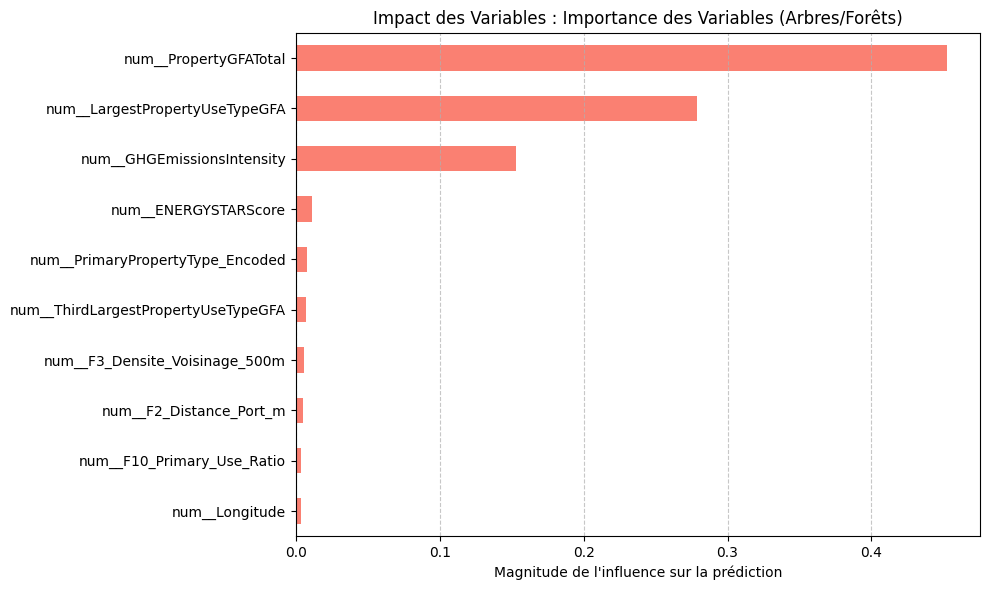

In [17]:
# ============================================================================
# INTERPRÉTABILITÉ : ANALYSE DE L'INFLUENCE DES VARIABLES
# ============================================================================

# 1. Identification des composants du pipeline
modelo_final     = best_pipeline.named_steps['model']
preprocesador    = best_pipeline.named_steps['preprocess']

# 2. Récupération des noms des caractéristiques après transformation
# Note : Indispensable suite au OneHotEncoding qui crée de nouvelles colonnes.
try:
    feature_names = preprocesador.get_feature_names_out()
except Exception:
    feature_names = X_train_global.columns

# 3. Extraction de la métrique d'influence (Importance ou Coefficients)
# Selon l'algorithme choisi, la méthode d'extraction varie.
if hasattr(modelo_final, 'feature_importances_'):
    valores      = modelo_final.feature_importances_
    titulo       = "Importance des Variables (Arbres/Forêts)"
elif hasattr(modelo_final, 'coef_'):
    # On utilise la valeur absolue pour mesurer la magnitude de l'impact.
    valores      = np.abs(modelo_final.coef_)
    titulo       = "Coefficients Absoluts (Modèle Linéaire)"
else:
    valores      = None

# ----------------------------------------------------------------------------
# GÉNÉRATION DU RAPPORT ET DU GRAPHIQUE
# ----------------------------------------------------------------------------
if valores is not None:
    # Création d'une Série Pandas pour faciliter le tri et l'affichage
    importancia_df = pd.Series(valores, index=feature_names).sort_values(
                     ascending = False
    )
    
    print("\n============================================================================")
    print(f"🔍 TOP 10 DES VARIABLES LES PLUS INFLUYENTES")
    print(f"   Source : {titulo}")
    print("============================================================================")
    
    # Affichage textuel avec alignement par points
    for i, (col, val) in enumerate(importancia_df.head(10).items(), 1):
        dot_fill = "." * (40 - len(col))
        print(f"  {i:02d}. {col}{dot_fill}: {val:.4f}")
    
    print("============================================================================")

    # Visualisation graphique (Barplot Horizontal)
    # L'analyse visuelle permet de détecter immédiatement les variables dominantes.
    plt.figure(figsize=(10, 6))
    importancia_df.head(10).plot(kind='barh', color='salmon')
    plt.gca().invert_yaxis()                                    # Plus fort en haut
    plt.title(f"Impact des Variables : {titulo}", fontsize=12)
    plt.xlabel("Magnitude de l'influence sur la prédiction")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## 5. 👤 ANALYSE COMPARATIVE ET VALIDATION DU MODÈLE


📈 5.1 - ANALYSE DES COURBES DE VALIDATION


C:\Users\Rafael CEREZO MARTIN\AppData\Local\Temp\ipykernel_8852\3365968860.py:102: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Rafael CEREZO MARTIN\AppData\Local\Temp\ipykernel_8852\3365968860.py:102: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Rafael CEREZO MARTIN\AppData\Local\Temp\ipykernel_8852\3365968860.py:103: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig('analyse_biais_variance.png', dpi=300, bbox_inches='tight')
C:\Users\Rafael CEREZO MARTIN\AppData\Local\Temp\ipykernel_8852\3365968860.py:103: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig('analyse_biais_variance.png', dpi=300, bbox_inches='tight')
C:\Users\Public\IAE_DELL\pra_dell\m3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canv

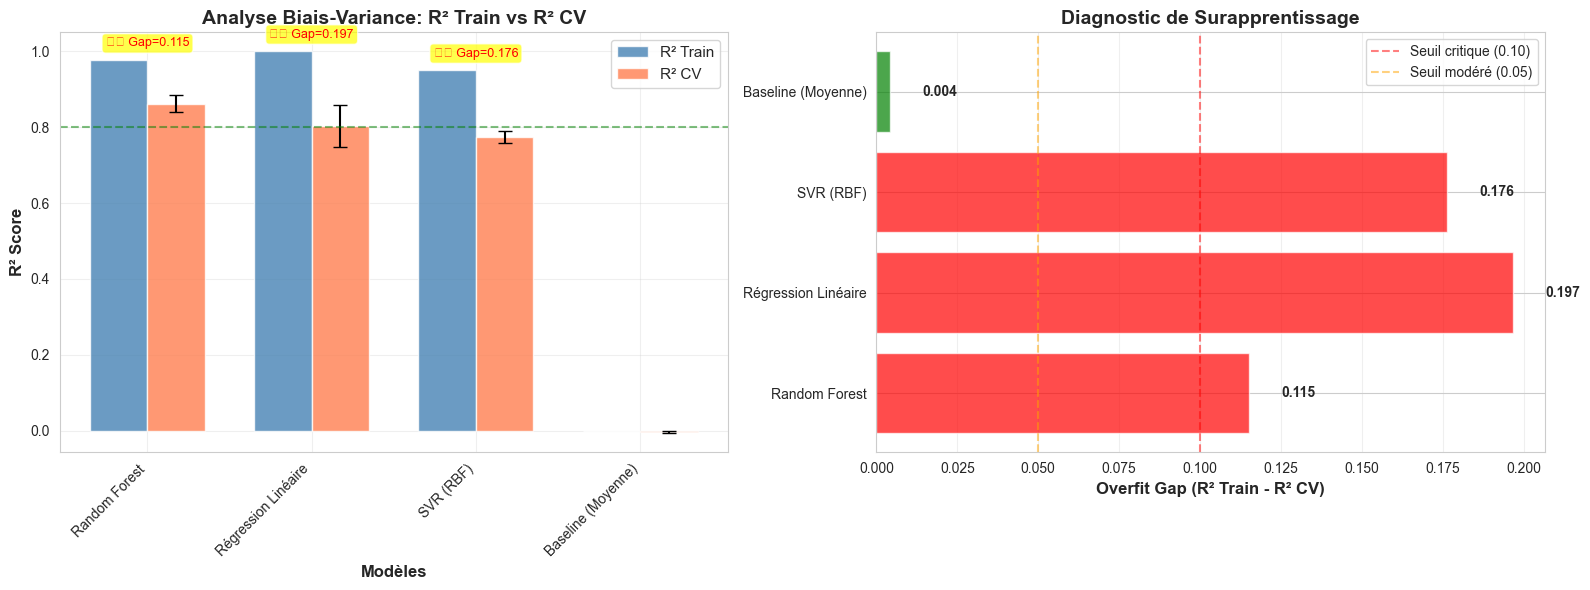


📊 Interprétation Biais-Variance:
  ❌ Random Forest             → Surapprentissage (gap = 0.115)
  ❌ Régression Linéaire       → Surapprentissage (gap = 0.197)
  ❌ SVR (RBF)                 → Surapprentissage (gap = 0.176)
  ✅ Baseline (Moyenne)        → Bon équilibre (gap = 0.004)

🔬 5.2 - INSPECTION DES RÉSIDUS

📊 Statistiques des résidus:
  • Moyenne............: 0.0197 (doit être ≈ 0)
  • Écart-type.........: 0.2156
  • Min / Max..........: -1.75 / 1.76


C:\Users\Rafael CEREZO MARTIN\AppData\Local\Temp\ipykernel_8852\3365968860.py:236: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Rafael CEREZO MARTIN\AppData\Local\Temp\ipykernel_8852\3365968860.py:236: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Rafael CEREZO MARTIN\AppData\Local\Temp\ipykernel_8852\3365968860.py:236: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Rafael CEREZO MARTIN\AppData\Local\Temp\ipykernel_8852\3365968860.py:237: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig('analyse_residus.png', dpi=300, bbox_inches='tight')
C:\Users\Rafael CEREZO MARTIN\AppData\Local\Temp\ipykernel_8852\3365968860.py:237: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig('analyse_residus.png', dpi=300, bbox_inches='tight')
C:\

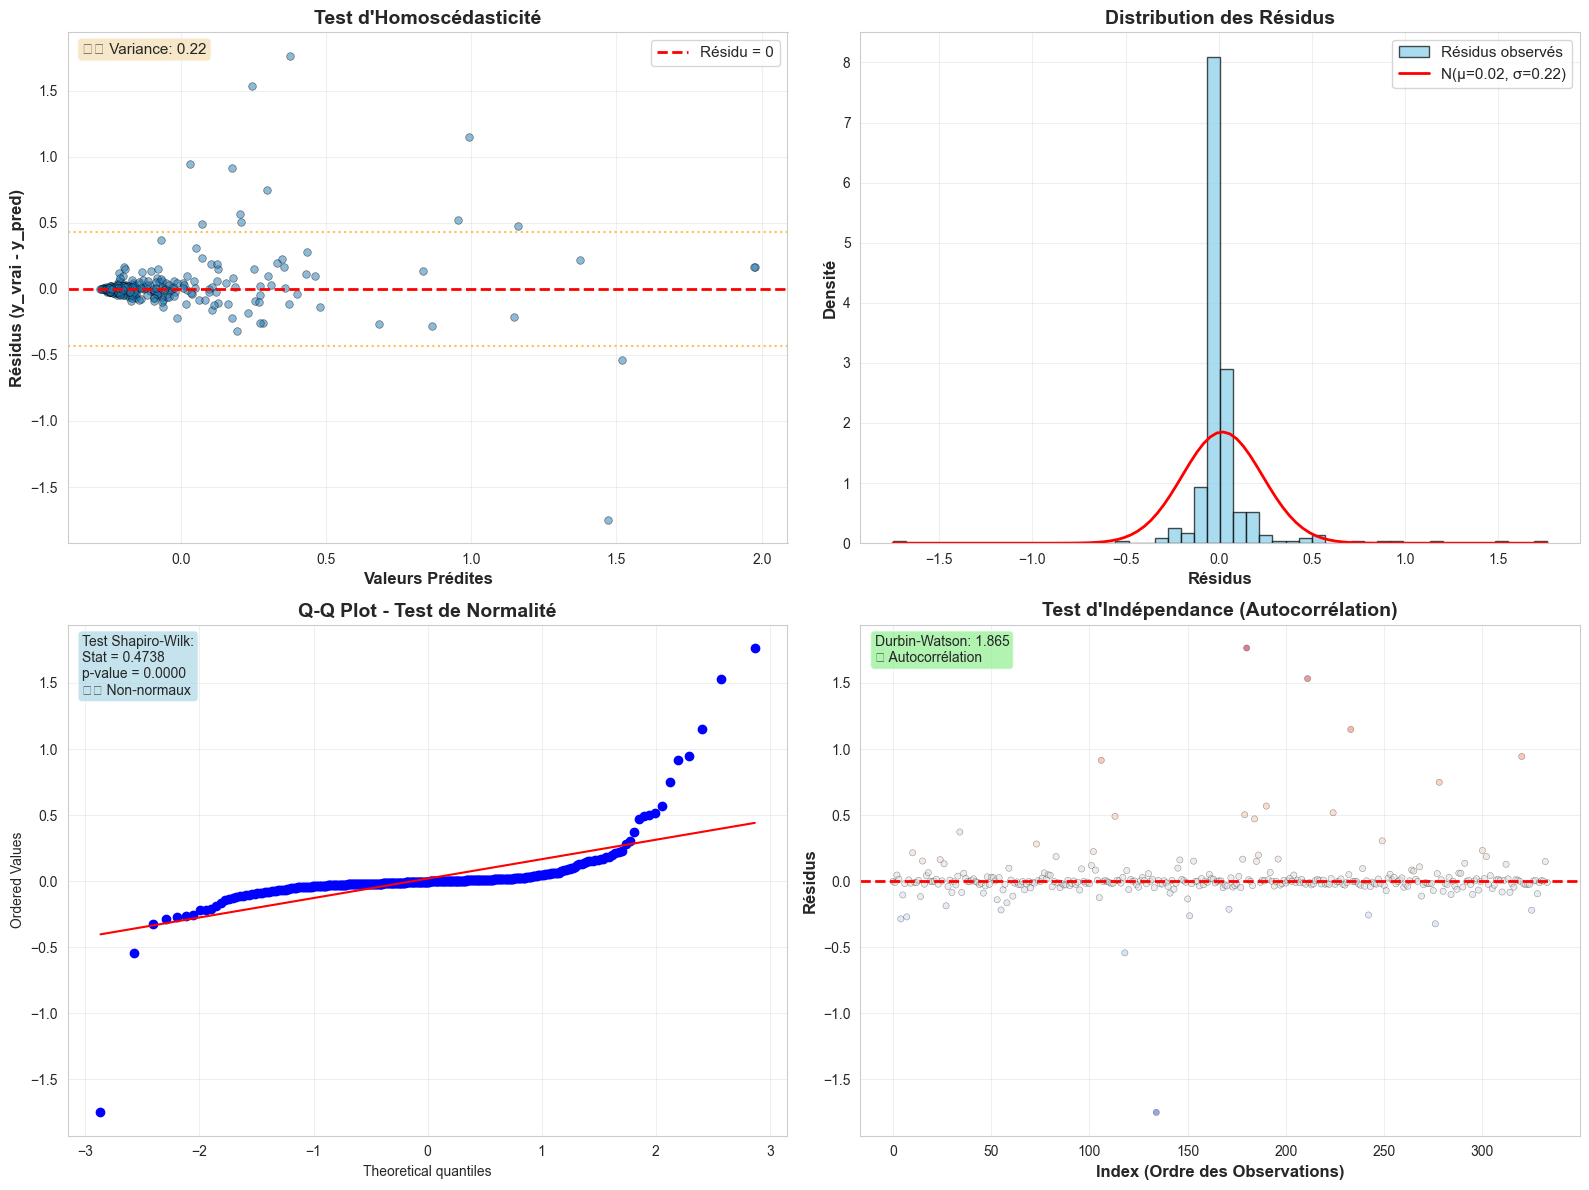


🔬 Diagnostic des Résidus:
  • Homoscédasticité...: ⚠️
  • Normalité..........: ⚠️ Non-normaux
  • Autocorrélation....: ✅

🎯 5.3 - IMPORTANCE DES FEATURES

🔄 Calcul de l'importance des features (peut prendre 1-2 min)...


KeyError: 'prep'

In [18]:
"""
================================================================================
ÉTAPE 5 - ANALYSE COMPARATIVE ET VALIDATION DU MODÈLE
================================================================================
Suite de l'évaluation sur test set. Analyse approfondie des performances.
================================================================================
"""

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from scipy              import stats
from sklearn.inspection import permutation_importance

# Configuration graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# ==============================================================================
# 5.1. ANALYSE DES COURBES DE VALIDATION (BIAIS VS VARIANCE)
# ==============================================================================
print("\n============================================================================")
print("📈 5.1 - ANALYSE DES COURBES DE VALIDATION")
print("============================================================================")

# ------------------------------------------------------------------------------
# Extraction des scores train et CV pour chaque modèle
# ------------------------------------------------------------------------------
models_names     = comparison_df['Modèle'].tolist()
r2_train_scores  = comparison_df['R² train (mean)'].tolist()
r2_cv_scores     = comparison_df['R² CV (mean)'].tolist()
r2_cv_stds       = comparison_df['R² CV (std)'].tolist()

# Créer figure avec 2 sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ------------------------------------------------------------------------------
# Graphique 1: Comparaison Train vs CV (Biais-Variance)
# ------------------------------------------------------------------------------
x_pos = np.arange(len(models_names))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, r2_train_scores, width, 
                label='R² Train', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, r2_cv_scores, width, 
                label='R² CV', color='coral', alpha=0.8,
                yerr=r2_cv_stds, capsize=5)

# Configuration du graphique
ax1.set_xlabel('Modèles', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Analyse Biais-Variance: R² Train vs R² CV', 
              fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_names, rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, 
            label='Seuil acceptable (0.80)')

# Ajouter annotations pour overfit gap
for i, (train, cv) in enumerate(zip(r2_train_scores, r2_cv_scores)):
    gap = train - cv
    if gap > 0.10:
        ax1.annotate(f'⚠️ Gap={gap:.3f}', 
                    xy=(i, train), 
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    fontsize=9,
                    color='red',
                    bbox=dict(boxstyle='round,pad=0.3', 
                             facecolor='yellow', alpha=0.7))

# ------------------------------------------------------------------------------
# Graphique 2: Overfit Gap (R² Train - R² CV)
# ------------------------------------------------------------------------------
overfit_gaps = [train - cv for train, cv in zip(r2_train_scores, r2_cv_scores)]

colors = ['red' if gap > 0.10 else 'orange' if gap > 0.05 else 'green' 
          for gap in overfit_gaps]

bars3 = ax2.barh(models_names, overfit_gaps, color=colors, alpha=0.7)

ax2.set_xlabel('Overfit Gap (R² Train - R² CV)', fontsize=12, fontweight='bold')
ax2.set_title('Diagnostic de Surapprentissage', fontsize=14, fontweight='bold')
ax2.axvline(x=0.10, color='red', linestyle='--', alpha=0.5, 
            label='Seuil critique (0.10)')
ax2.axvline(x=0.05, color='orange', linestyle='--', alpha=0.5, 
            label='Seuil modéré (0.05)')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='x')

# Ajouter valeurs sur les barres
for i, (gap, bar) in enumerate(zip(overfit_gaps, bars3)):
    ax2.text(gap + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{gap:.3f}',
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('analyse_biais_variance.png', dpi=300, bbox_inches='tight')
plt.show()

# Interprétation automatique
print("\n📊 Interprétation Biais-Variance:")
for name, gap in zip(models_names, overfit_gaps):
    if gap > 0.10:
        print(f"  ❌ {name:25} → Surapprentissage (gap = {gap:.3f})")
    elif gap > 0.05:
        print(f"  ⚠️  {name:25} → Léger surapprentissage (gap = {gap:.3f})")
    elif gap < -0.05:
        print(f"  ⚠️  {name:25} → Sous-apprentissage possible (gap = {gap:.3f})")
    else:
        print(f"  ✅ {name:25} → Bon équilibre (gap = {gap:.3f})")


# ==============================================================================
# 5.2. INSPECTION DES RÉSIDUS (HOMOSCÉDASTICITÉ ET NORMALITÉ)
# ==============================================================================
print("\n============================================================================")
print("🔬 5.2 - INSPECTION DES RÉSIDUS")
print("============================================================================")

# ------------------------------------------------------------------------------
# Calcul des résidus sur le jeu de test
# ------------------------------------------------------------------------------
residus          = y_test_global - y_pred_test
residus_std      = (residus - residus.mean()) / residus.std()  # Standardisés

print(f"\n📊 Statistiques des résidus:")
print(f"  • Moyenne............: {residus.mean():.4f} (doit être ≈ 0)")
print(f"  • Écart-type.........: {residus.std():.4f}")
print(f"  • Min / Max..........: {residus.min():.2f} / {residus.max():.2f}")

# Créer figure avec 4 sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ------------------------------------------------------------------------------
# Graphique 1: Résidus vs Prédictions (Test Homoscédasticité)
# ------------------------------------------------------------------------------
ax = axes[0, 0]
ax.scatter(y_pred_test, residus, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Résidu = 0')
ax.set_xlabel('Valeurs Prédites', fontsize=12, fontweight='bold')
ax.set_ylabel('Résidus (y_vrai - y_pred)', fontsize=12, fontweight='bold')
ax.set_title('Test d\'Homoscédasticité', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Ajouter bandes de confiance
std_res = residus.std()
ax.axhline(y=2*std_res, color='orange', linestyle=':', alpha=0.7, 
           label='±2σ (95%)')
ax.axhline(y=-2*std_res, color='orange', linestyle=':', alpha=0.7)

# Annotation
homoscedastic = "✅" if residus.std() / residus.mean() < 5 else "⚠️"
ax.text(0.02, 0.98, f'{homoscedastic} Variance: {residus.std():.2f}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# ------------------------------------------------------------------------------
# Graphique 2: Distribution des Résidus (Histogramme + Courbe normale)
# ------------------------------------------------------------------------------
ax = axes[0, 1]
ax.hist(residus, bins=50, density=True, alpha=0.7, color='skyblue', 
        edgecolor='black', label='Résidus observés')

# Superposer courbe normale théorique
mu, sigma = residus.mean(), residus.std()
x = np.linspace(residus.min(), residus.max(), 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
        label=f'N(μ={mu:.2f}, σ={sigma:.2f})')

ax.set_xlabel('Résidus', fontsize=12, fontweight='bold')
ax.set_ylabel('Densité', fontsize=12, fontweight='bold')
ax.set_title('Distribution des Résidus', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# ------------------------------------------------------------------------------
# Graphique 3: Q-Q Plot (Test de Normalité)
# ------------------------------------------------------------------------------
ax = axes[1, 0]
stats.probplot(residus, dist="norm", plot=ax)
ax.set_title('Q-Q Plot - Test de Normalité', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Test de normalité (Shapiro-Wilk)
# Note: Sur grands datasets (n>5000), utiliser plutôt Kolmogorov-Smirnov
if len(residus) <= 5000:
    stat_shapiro, p_value_shapiro = stats.shapiro(residus)
    test_name = "Shapiro-Wilk"
    stat_test = stat_shapiro
    p_value = p_value_shapiro
else:
    stat_ks, p_value_ks = stats.kstest(residus_std, 'norm')
    test_name = "Kolmogorov-Smirnov"
    stat_test = stat_ks
    p_value = p_value_ks

normal_status = "✅ Normaux" if p_value > 0.05 else "⚠️ Non-normaux"
ax.text(0.02, 0.98, 
        f'Test {test_name}:\n'
        f'Stat = {stat_test:.4f}\n'
        f'p-value = {p_value:.4f}\n'
        f'{normal_status}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# ------------------------------------------------------------------------------
# Graphique 4: Résidus vs Ordre (Test d'Autocorrélation)
# ------------------------------------------------------------------------------
ax = axes[1, 1]
ax.scatter(range(len(residus)), residus, alpha=0.5, s=20, c=residus, 
           cmap='coolwarm', edgecolors='k', linewidth=0.3)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Index (Ordre des Observations)', fontsize=12, fontweight='bold')
ax.set_ylabel('Résidus', fontsize=12, fontweight='bold')
ax.set_title('Test d\'Indépendance (Autocorrélation)', fontsize=14, 
             fontweight='bold')
ax.grid(True, alpha=0.3)

# Test de Durbin-Watson pour autocorrélation
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residus)
autocorr_status = "✅" if 1.5 < dw_stat < 2.5 else "⚠️"
ax.text(0.02, 0.98, 
        f'Durbin-Watson: {dw_stat:.3f}\n'
        f'{autocorr_status} Autocorrélation',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.savefig('analyse_residus.png', dpi=300, bbox_inches='tight')
plt.show()

# Diagnostic final des résidus
print(f"\n🔬 Diagnostic des Résidus:")
print(f"  • Homoscédasticité...: {homoscedastic}")
print(f"  • Normalité..........: {normal_status}")
print(f"  • Autocorrélation....: {autocorr_status}")




🎯 5.3 - IMPORTANCE DES FEATURES

🔄 Calcul de l'importance des features (peut prendre 1-2 min)...

🔍 Steps dans le pipeline: ['preprocess', 'model']
✅ 4491 noms de features extraits du preprocessor
❌ Erreur: 4491 noms vs 48 importances
✅ Correction: utilisation de 48 noms génériques
Nombres: 4491 | Importancias: 48
⚠️ Desajuste detectado. Ajustando a los 48 valores del modelo.

📊 Top 20 Features les plus importantes:
  Feature_10 (N/A)                         | 0.6135 ± 0.0415 | █████████████████████████████████████████████████████████████
  Feature_22 (N/A)                         | 0.3124 ± 0.0475 | ███████████████████████████████
  Feature_14 (N/A)                         | 0.0401 ± 0.0154 | ████
  Feature_20 (N/A)                         | 0.0131 ± 0.0035 | █
  Feature_47 (N/A)                         | 0.0044 ± 0.0025 | 
  Feature_33 (N/A)                         | 0.0035 ± 0.0018 | 
  Feature_18 (N/A)                         | 0.0029 ± 0.0023 | 
  Feature_15 (N/A)                

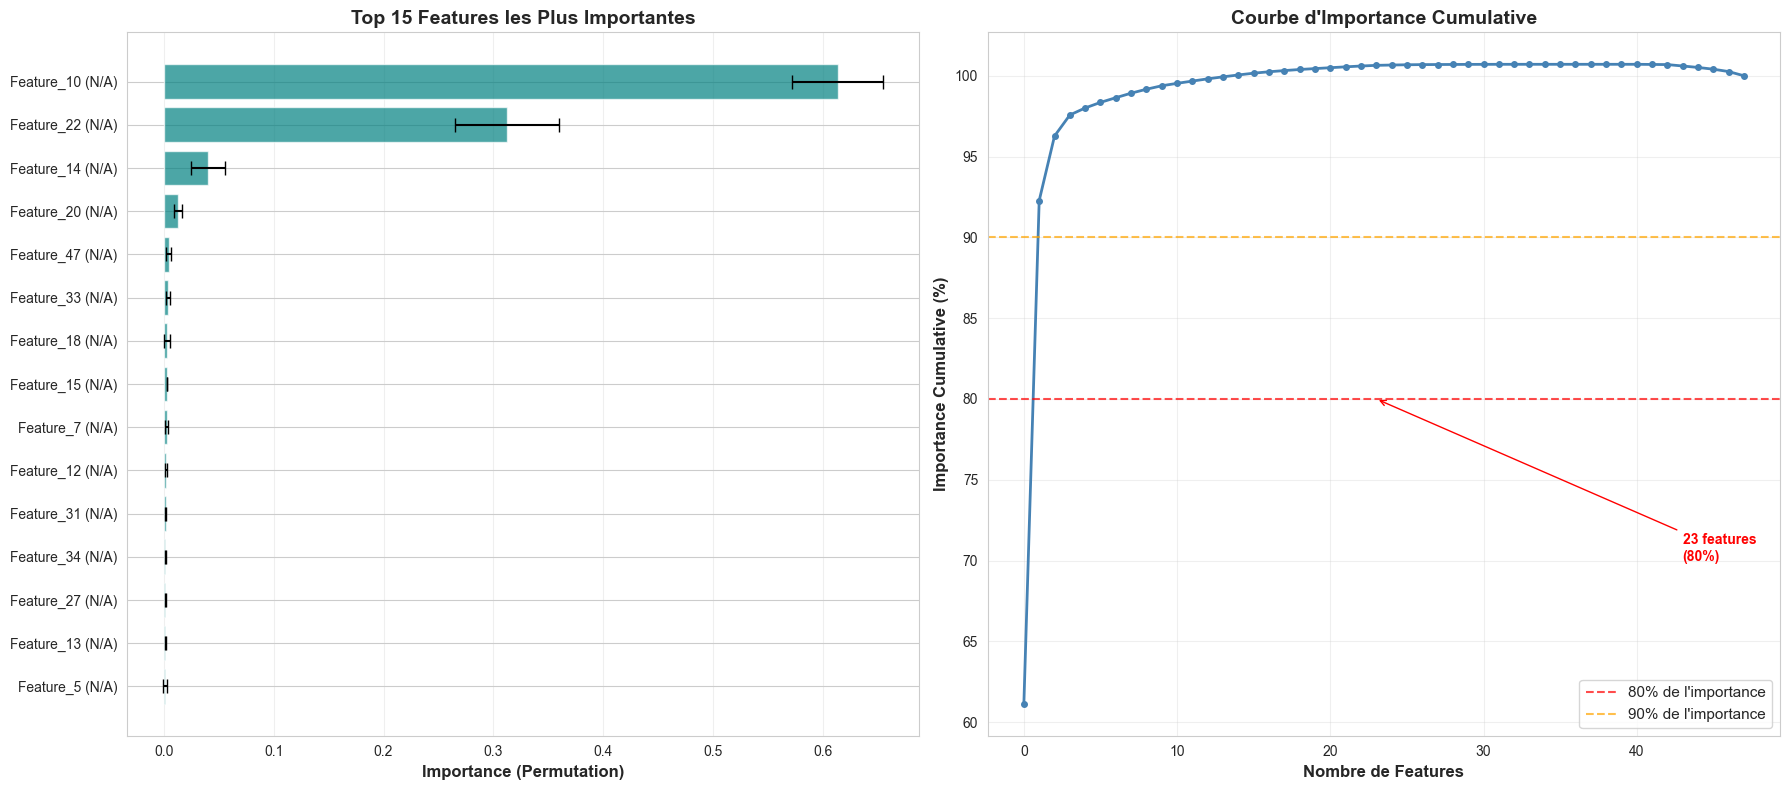


🎯 Insights sur les Features:
  • 23 features capturent 80% de l'importance
  • 23 features capturent 90% de l'importance
  • Total de features: 48

✅ RAPPORT FINAL D'ANALYSE

🏆 Modèle Sélectionné: Random Forest

📊 Performance Test Set:
  • R² Score..........: 0.6934
  • MAE...............: 0.08
  • RMSE..............: 0.22

🔬 Qualité des Résidus:
  • Homoscédasticité..: ⚠️
  • Normalité.........: ⚠️ Non-normaux
  • Autocorrélation...: ✅

🎯 Features Clés:
  • Top 3.............: Feature_10 (N/A), Feature_22 (N/A), Feature_14 (N/A)
  • Pour 80% importance: 23 features

📁 Fichiers générés:
  • analyse_biais_variance.png
  • analyse_residus.png
  • importance_features.png


In [23]:

# ==============================================================================
# 5.3. IMPORTANCE DES FEATURES (PERMUTATION IMPORTANCE)
# ==============================================================================
print("\n============================================================================")
print("🎯 5.3 - IMPORTANCE DES FEATURES")
print("============================================================================")

# ------------------------------------------------------------------------------
# Calcul de l'importance par permutation (méthode model-agnostic)
# ------------------------------------------------------------------------------
print("\n🔄 Calcul de l'importance des features (peut prendre 1-2 min)...")

# Permutation importance sur le test set
perm_importance = permutation_importance(
    best_pipeline,
    X_test_global,
    y_test_global,
    n_repeats=10,          # Nombre de permutations par feature
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)

# ------------------------------------------------------------------------------
# RÉCUPÉRATION DES NOMS DES FEATURES (CORRECTION)
# ------------------------------------------------------------------------------
# Vérifier les noms des steps dans le pipeline
print(f"\n🔍 Steps dans le pipeline: {list(best_pipeline.named_steps.keys())}")

try:
    # Essayer différents noms possibles
    if 'prep' in best_pipeline.named_steps:
        preprocessor = best_pipeline.named_steps['prep']
    elif 'preprocessing' in best_pipeline.named_steps:
        preprocessor = best_pipeline.named_steps['preprocessing']
    elif 'preprocess' in best_pipeline.named_steps:
        preprocessor = best_pipeline.named_steps['preprocess']
    else:
        # Prendre le premier step qui n'est pas le modèle
        step_names = list(best_pipeline.named_steps.keys())
        preprocessor = best_pipeline.named_steps[step_names[0]]
    
    # Essayer d'obtenir les noms des features
    feature_names = preprocessor.get_feature_names_out()
    print(f"✅ {len(feature_names)} noms de features extraits du preprocessor")
    
except (AttributeError, KeyError) as e:
    print(f"⚠️  Impossible d'extraire les noms des features: {e}")
    
    # Fallback 1: Utiliser les noms des colonnes originales de X_test_global
    if hasattr(X_test_global, 'columns'):
        feature_names = X_test_global.columns.tolist()
        print(f"✅ Utilisation des noms de colonnes originales: {len(feature_names)} features")
    else:
        # Fallback 2: Noms génériques
        n_features = perm_importance.importances_mean.shape[0]
        feature_names = [f'Feature_{i}' for i in range(n_features)]
        print(f"⚠️  Utilisation de noms génériques: {len(feature_names)} features")

# Vérifier que le nombre de features correspond
if len(feature_names) != len(perm_importance.importances_mean):
    print(f"❌ Erreur: {len(feature_names)} noms vs "
          f"{len(perm_importance.importances_mean)} importances")
    # Ajuster si nécessaire
    n_features = len(perm_importance.importances_mean)
    feature_names = [f'Feature_{i}' for i in range(n_features)]
    print(f"✅ Correction: utilisation de {n_features} noms génériques")


nombres_reales = preprocessor.get_feature_names_out()

# Verificar longitudes antes de crear el DataFrame
print(f"Nombres: {len(nombres_reales)} | Importancias: {len(perm_importance.importances_mean)}")

# 2. Obtener nombres de columnas TRANSFORMADAS
# Esto asegura que si hubo One-Hot Encoding, los nombres coincidan con la matriz final
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    # Si falla, intentamos reconstruir desde las columnas que vio el modelo
    print("⚠️ Fallo get_feature_names_out, usando nombres del input...")
    feature_names = X_test_global.columns.tolist()

# 3. Validar y recortar/ajustar si es necesario (Safety Break)
if len(feature_names) != len(perm_importance.importances_mean):
    print(f"⚠️ Desajuste detectado. Ajustando a los {len(perm_importance.importances_mean)} valores del modelo.")
    # Usamos nombres genéricos solo como último recurso para evitar que el código muera
    feature_names = [f"Feature_{i} (N/A)" for i in range(len(perm_importance.importances_mean))]
    

# Créer DataFrame avec importance
# Ahora importancia_df tendrá los nombres correctos
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)


# Afficher top 20
print(f"\n📊 Top 20 Features les plus importantes:")
print("="*80)
for i, row in importance_df.head(20).iterrows():
    bar = '█' * int(row['Importance'] * 100)
    print(f"  {row['Feature']:40} | {row['Importance']:6.4f} ± {row['Std']:.4f} "
          f"| {bar}")
print("="*80)

# ------------------------------------------------------------------------------
# Visualisation de l'importance
# ------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Graphique 1: Top 15 features
top_n = 15
top_features = importance_df.head(top_n)

ax1.barh(range(top_n), top_features['Importance'], 
         xerr=top_features['Std'], color='teal', alpha=0.7, capsize=5)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_features['Feature'])
ax1.set_xlabel('Importance (Permutation)', fontsize=12, fontweight='bold')
ax1.set_title(f'Top {top_n} Features les Plus Importantes', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Graphique 2: Distribution cumulative
cumsum = importance_df['Importance'].cumsum() / importance_df['Importance'].sum()

ax2.plot(range(len(cumsum)), cumsum * 100, marker='o', linewidth=2, 
         markersize=4, color='steelblue')
ax2.axhline(y=80, color='red', linestyle='--', alpha=0.7, 
            label='80% de l\'importance')
ax2.axhline(y=90, color='orange', linestyle='--', alpha=0.7, 
            label='90% de l\'importance')
ax2.set_xlabel('Nombre de Features', fontsize=12, fontweight='bold')
ax2.set_ylabel('Importance Cumulative (%)', fontsize=12, fontweight='bold')
ax2.set_title('Courbe d\'Importance Cumulative', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Trouver combien de features pour 80% et 90%
n_80 = (cumsum >= 0.80).idxmax() + 1
n_90 = (cumsum >= 0.90).idxmax() + 1

ax2.annotate(f'{n_80} features\n(80%)', 
            xy=(n_80, 80), xytext=(n_80 + 20, 70),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, fontweight='bold', color='red')

plt.tight_layout()
plt.savefig('importance_features.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎯 Insights sur les Features:")
print(f"  • {n_80} features capturent 80% de l'importance")
print(f"  • {n_90} features capturent 90% de l'importance")
print(f"  • Total de features: {len(feature_names)}")


# ==============================================================================
# RAPPORT FINAL
# ==============================================================================
print("\n" + "="*80)
print("✅ RAPPORT FINAL D'ANALYSE")
print("="*80)
print(f"\n🏆 Modèle Sélectionné: {best_model_name}")
print(f"\n📊 Performance Test Set:")
print(f"  • R² Score..........: {r2_test:.4f}")
print(f"  • MAE...............: {mae_test:.2f}")
print(f"  • RMSE..............: {rmse_test:.2f}")
print(f"\n🔬 Qualité des Résidus:")
print(f"  • Homoscédasticité..: {homoscedastic}")
print(f"  • Normalité.........: {normal_status}")
print(f"  • Autocorrélation...: {autocorr_status}")
print(f"\n🎯 Features Clés:")
print(f"  • Top 3.............: {', '.join(importance_df.head(3)['Feature'].tolist())}")
print(f"  • Pour 80% importance: {n_80} features")
print("\n" + "="*80)
print("📁 Fichiers générés:")
print("  • analyse_biais_variance.png")
print("  • analyse_residus.png")
print("  • importance_features.png")
print("="*80)